In [15]:
import numpy as np
from matplotlib import pyplot as plt
from utils import CarTrajectoryNonLinear, UKF, plot_trajectory, conf_ellipse

from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn

from matplotlib import animation, rc

In [16]:
system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

f = system.f
F_jacobian = system.F_jacobian
h = system.h
H_jacobian = system.H_jacobian
Q = system.Q
R = system.R

In [17]:
def systematic_resampling(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


P = np.eye(4)
m = states[0]
estimated_trajectory_particle = np.empty((len(measurements), len(m)))
estimated_trajectory_particle[0] = m

P_particle = np.zeros((len(measurements), len(m), len(m)))
P_particle[0] = P

# Draw N samples from the prior
N = 1000
particles = mvn(m, P).rvs(N)
weights = np.ones(N) / N

particles_hist = np.empty((len(measurements), N, len(m)))
particles_hist[0] = particles

weights_hist = np.empty((len(measurements), N))
weights_hist[0] = weights

# SIR particle filter
for idx, y in tqdm(enumerate(measurements[1:], 1), total=len(measurements[1:])):
    particles = np.array([f(particle) for particle in particles]) + mvn([0, 0, 0, 0], Q).rvs(N)
    
    # Update weights
    for i, particle in enumerate(particles):
        pi_dist = scipy.stats.multivariate_normal(h(particle), R)
        weights[i] *= pi_dist.pdf(y)
        
    weights += 1.e-300 # avoid round-off to zero
    weights /= sum(weights)
    
    if 1. / np.sum(np.square(weights)) < N / 2:
        indexes = systematic_resampling(weights)
        
        # Resample from index
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    m = np.average(particles, weights=weights, axis=0)
    # Calculate covariance matrix of particles
    P = np.zeros((4, 4))
    for particle, weight in zip(particles, weights):
        diff = (particle - m)[np.newaxis]
        P += weight * np.dot(diff.T, diff)
    
    estimated_trajectory_particle[idx] = m
    P_particle[idx] = P
    particles_hist[idx] = particles
    weights_hist[idx] = weights

100%|██████████| 99/99 [00:20<00:00,  4.84it/s]


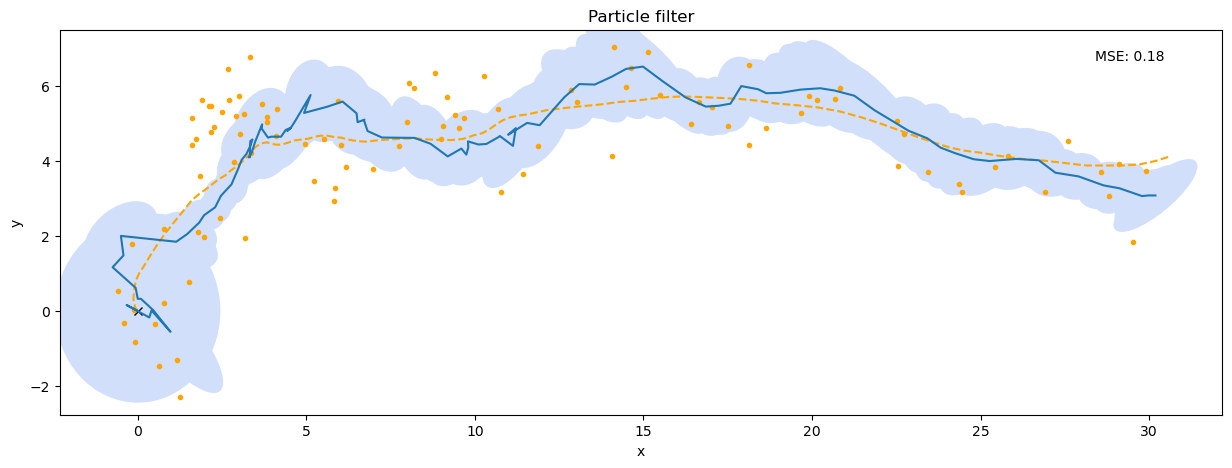

In [18]:
#Compare methods
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = [ax]
for k in range(1):
    ax[k].plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
    ax[k].plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_particle[:, 0], estimated_trajectory_particle[:, 1])  
ax[0].set_title("Particle filter")

# Compute MSE
UP1_MSE = np.mean((states[:, :2] - estimated_trajectory_particle[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(UP1_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_particle)):
    conf_ellipse(ax[0], estimated_trajectory_particle[i, :2], P_particle[i, :2, :2])
    
plt.show()

# Animation

  0%|          | 0/100 [00:00<?, ?it/s]MovieWriter Pillow unavailable; using Pillow instead.


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


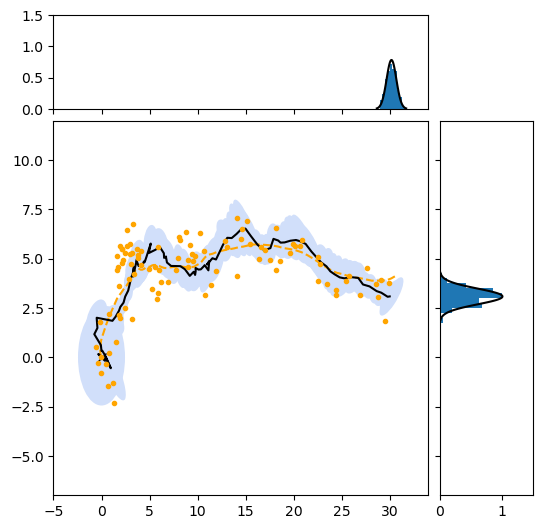

In [19]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])

ax.plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
ax.plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

line, =  ax.plot([],[], '-', color='black', label="Estimated trajectory")

#    ax.plot(estimated_trajectory_particle[frame, 0], estimated_trajectory_particle[frame, 1], '-', color='black', label="Estimated trajectory")
# Function to initialize the plot
def init():
    ax.set_xlim(int(np.min(measurements[:, 0]) - 5), int(np.max(measurements[:, 0] + 5)))
    ax.set_ylim(int(np.min(measurements[:, 1]) - 5), int(np.max(measurements[:, 1] + 5)))
    ax_histx.set_ylim(0, 1.0)
    ax_histy.set_xlim(0, 1.0)
    return ax,

# Function to update the plot for each frame
def update(frame):
    x = particles_hist[frame, :, 0]  # Select X coordinates of particles at a given time
    y = particles_hist[frame, :, 1]  # Select Y coordinates of particles at a given time
    #ax.scatter(x, y, c='b', marker='.', alpha=0.1)
    ax.plot(measurements[frame, 0], measurements[frame, 1], '.', color='orange', label="Noisy observations")
    conf_ellipse(ax, estimated_trajectory_particle[frame, :2], P_particle[frame, :2, :2])
    
    line.set_xdata(estimated_trajectory_particle[:frame, 0])
    line.set_ydata(estimated_trajectory_particle[:frame, 1])    
    
    ax_histx.clear()
    ax_histy.clear()
    ax_histx.set_ylim(0, 1.5)
    ax_histy.set_xlim(0, 1.5)
    
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    ax_histx.hist(x, bins=bins, density=True)
    tmp_x  = np.linspace(estimated_trajectory_particle[frame, 0] - 3 * np.sqrt(P_particle[frame, 0, 0]),
                            estimated_trajectory_particle[frame, 0] + 3 * np.sqrt(P_particle[frame, 0, 0]), 100)
    ax_histx.plot(tmp_x, scipy.stats.norm.pdf(tmp_x, estimated_trajectory_particle[frame, 0], np.sqrt(P_particle[frame, 0, 0])), tmp_x, color='black')    
    
    ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)
    tmp_y  = np.linspace(estimated_trajectory_particle[frame, 1] - 3 * np.sqrt(P_particle[frame, 1, 1]),
                            estimated_trajectory_particle[frame, 1] + 3 * np.sqrt(P_particle[frame, 1, 1]), 100)
    ax_histy.plot(scipy.stats.norm.pdf(tmp_y, estimated_trajectory_particle[frame, 1], np.sqrt(P_particle[frame, 1, 1])), tmp_y, color='black')
    
    return ax,

# Save animation with progress bar
with tqdm(total=len(particles_hist)) as pbar:
    ani = animation.FuncAnimation(fig, update, frames=range(0, len(particles_hist)), init_func=init)
    ani.save('particle.gif', writer='Pillow', fps=7, progress_callback=lambda i, n: pbar.update())